In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import gc

from sklearn.decomposition import PCA

import torch.nn.functional as F

from IPython.display import clear_output

from src.NOT.tools import unfreeze, freeze
# from src.NOT.plotters import plot_generated_2D, plot_bar_and_stochastic_2D

from metrics import compute_BW_UVP_by_gt_samples, calculate_cond_bw
from gaussian_mixture_benchmark import get_guassian_mixture_benchmark_sampler, get_guassian_mixture_benchmark_ground_truth_sampler, get_test_input_samples

from tqdm.notebook import tqdm as tqdm
import wandb

In [2]:
DEVICE_IDS = [0]

DIM = 2
EPSILON = 0.1

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4

ZD = 0
Z_STD = 0
H = 100

BATCH_SIZE = 128
Z_SIZE = 4

PLOT_INTERVAL = 200
MAX_STEPS = 10001
SEED = 42

In [3]:
assert torch.cuda.is_available()
device = torch.device(f'cuda:{DEVICE_IDS[0]}')
torch.cuda.set_device(DEVICE_IDS[0])
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
EXP_NAME = f'NOT_benchmark_EPSILON_{EPSILON}_DIM_{DIM}_SEED_{SEED}'
OUTPUT_PATH = '../checkpoints/{}'.format(EXP_NAME)

config = dict(
    DIM=DIM,
    EPSILON=EPSILON,
    BATCH_SIZE=BATCH_SIZE,
    H=H,
    ZD=ZD,
    Z_STD=Z_STD,
    T_LR=T_LR,
    f_LR=f_LR,
    T_ITERS=T_ITERS,
    PLOT_INTERVAL=PLOT_INTERVAL,
    MAX_STEPS=MAX_STEPS,
    SEED=SEED,
)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [5]:
X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPSILON,
                                                   batch_size=BATCH_SIZE, device=device, download=False)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPSILON,
                                                   batch_size=BATCH_SIZE, device=device, download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPSILON,
                                                                                batch_size=BATCH_SIZE, 
                                                                                device=device,
                                                                                download=False)

In [6]:
pca = PCA(n_components=2)

samples = X_sampler.sample(10000)
samples = samples.cpu()

target_samples = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

pca.fit(target_samples)

PCA(n_components=2)

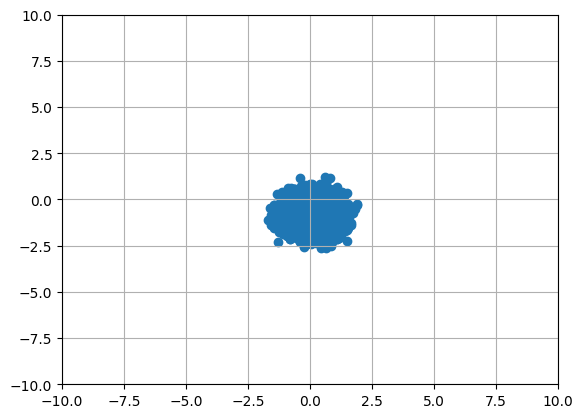

In [7]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()

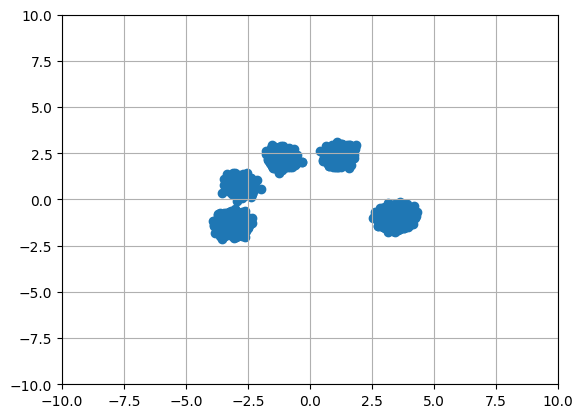

In [8]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()

In [9]:
def pca_plot(x_0_gt, x_1_gt, x_1_pred, n_plot, step):
    fig,axes = plt.subplots(1, 3,figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    pca = PCA(n_components=2).fit(x_1_gt)
    
    x_0_gt_pca = pca.transform(x_0_gt[:n_plot])
    x_1_gt_pca = pca.transform(x_1_gt[:n_plot])
    x_1_pred_pca = pca.transform(x_1_pred[:n_plot])
    
    axes[0].scatter(x_0_gt_pca[:,0], x_0_gt_pca[:,1], c="g", edgecolor = 'black',
                    label = r'$x\sim P_0(x)$', s =30)
    axes[1].scatter(x_1_gt_pca[:,0], x_1_gt_pca[:,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =30)
    axes[2].scatter(x_1_pred_pca[:,0], x_1_pred_pca[:,1], c="yellow", edgecolor = 'black',
                    label = r'$x\sim T(x)$', s =30)
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-10, 10])
        axes[i].set_ylim([-10, 10])
        axes[i].legend()
    
    fig.tight_layout(pad=0.5)

def plot_mapping(independent_mapping, true_mapping, predicted_mapping, target_data, n_plot, step):
    s=30
    linewidth=0.2
    map_alpha=1
    data_alpha=1
    figsize=(5, 5)
    dpi=None
    data_color='red'
    mapped_data_color='blue'
    map_color='green'
    map_label=None
    data_label=None
    mapped_data_label=None
    
    dim = target_data.shape[-1]
    pca = PCA(n_components=2).fit(target_data)
    
    independent_mapping_pca = np.concatenate((        
        pca.transform(independent_mapping[:n_plot, :dim]),
        pca.transform(independent_mapping[:n_plot, dim:]),
        ), axis=-1)
 
    true_mapping_pca = np.concatenate((
        pca.transform(true_mapping[:n_plot, :dim]),
        pca.transform(true_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    predicted_mapping_pca = np.concatenate((
        pca.transform(predicted_mapping[:n_plot, :dim]),
        pca.transform(predicted_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    target_data_pca = pca.transform(target_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    titles = ["independent", "true", "predicted"]
    for i, mapping in enumerate([independent_mapping_pca, true_mapping_pca, predicted_mapping_pca]):
        inp = mapping[:, :2]
        out = mapping[:, 2:]

        lines = np.concatenate([inp, out], axis=-1).reshape(-1, 2, 2)
        lc = matplotlib.collections.LineCollection(
            lines, color=map_color, linewidths=linewidth, alpha=map_alpha, label=map_label)
        axes[i].add_collection(lc)

        axes[i].scatter(
            inp[:, 0], inp[:, 1], s=s, label=data_label,
            alpha=data_alpha, zorder=2, color=data_color)
        axes[i].scatter(
            out[:, 0], out[:, 1], s=s, label=mapped_data_label,
            alpha=data_alpha, zorder=2, color=mapped_data_color)

        axes[i].scatter(target_data_pca[:1000,0], target_data_pca[:1000,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =10)
        axes[i].grid()
        axes[i].set_title(titles[i])
    

    
    
def pca_plot_plan(independent_plan, true_plan, predicted_plan, n_plot, step):
    fig,axes = plt.subplots(1, 3,figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    pca = PCA(n_components=2).fit(true_plan)
    
    predicted_plan_pca = pca.transform(predicted_plan[:n_plot])
    true_plan_pca = pca.transform(true_plan[:n_plot])
    independent_plan_pca = pca.transform(independent_plan[:n_plot])
    
    axes[0].scatter(independent_plan_pca[:,0], independent_plan_pca[:,1], c="g", edgecolor = 'black',
                    label = r'Independent plan', s =30)
    axes[1].scatter(true_plan_pca[:,0], true_plan_pca[:,1], c="orange", edgecolor = 'black',
                    label = r'True plan', s =30)
    axes[2].scatter(predicted_plan_pca[:,0], predicted_plan_pca[:,1], c="yellow", edgecolor = 'black',
                    label = r'Predicted plan', s =30)
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-10, 10])
        axes[i].set_ylim([-10, 10])
        axes[i].legend()
    
    fig.tight_layout(pad=0.5)

In [10]:
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

T = nn.Sequential(
    nn.Linear(DIM+ZD, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

f = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

T.apply(weights_init_mlp); f.apply(weights_init_mlp)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 20702
f params: 20601


In [11]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

Step 10000
Plotting


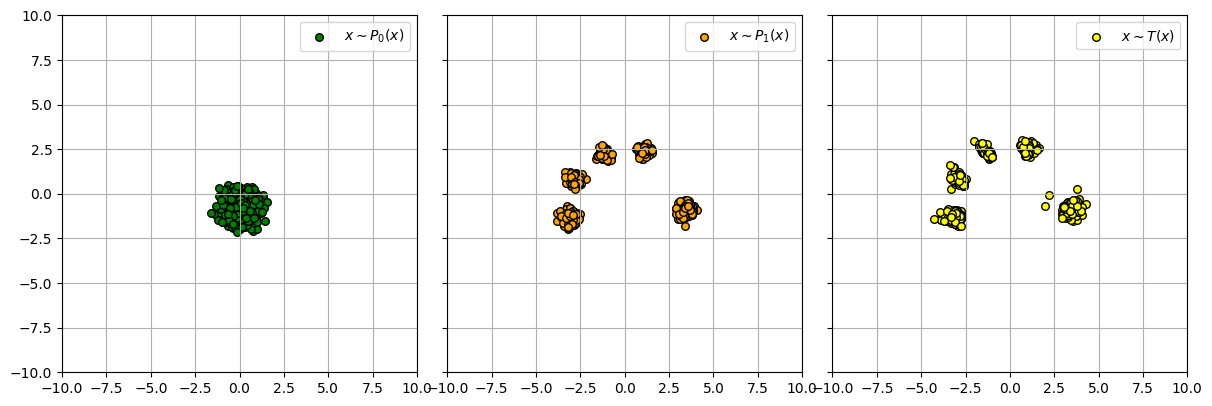

  0%|          | 0/1000 [00:00<?, ?it/s]

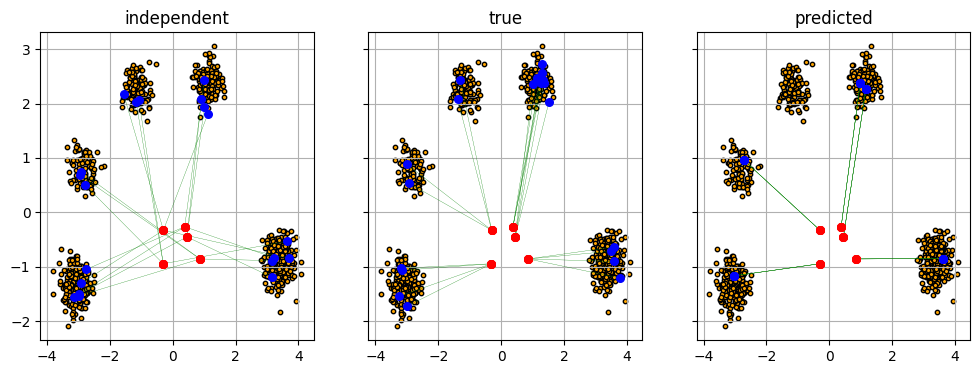

Step 10000 - BW-UVP: 0.06955048342786864, COND-BW: 14.573366753021883
Total training time: 4355.7125244140625 seconds


T_loss,-4.19033
f_loss,0.21909
BW-UVP_target,0.06955
new_cond_bw,14.57337
Step time,3.39687
_runtime,4363
_timestamp,1717403976
_step,10000
Total training time,4355.71252


T_loss,▁▁▁▂▂▃▁▁▂▂▃▃▂▂▂▂▁▂▃▃▃▄▁▃▂▁▂▄▂▃▆▃▃▃▂▂█▆▅▅
f_loss,▇▃▅▃▄▅▅▄▅▇▃▄▄▆██▅▅▃▄▁▃▃▅▇▆▄██▂▂▁▆▅▅▃▄▃▂▂
BW-UVP_target,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
new_cond_bw,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Step time,▃▂▂▁▂▂▁▁▁▁▂▁▁▂▃▃▄▃▃█▃▃▆▃▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Total training time,▁


In [12]:
wandb.init(name=EXP_NAME, config=config)

bw_uvp_metrics = []
cond_bw_metrics = []

start_time = time.time()
for step in tqdm(range(MAX_STEPS)):
    step_start_time = time.time()
    
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE).reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZD, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)

        T_loss = F.mse_loss(X[:, 0], T_XZ.mean(dim=1)).mean() - f(
            T_XZ.flatten(start_dim=0, end_dim=1)).mean() - T_XZ.var(dim=1).mean() / Z_SIZE
        T_loss.backward(); T_opt.step()
        if t_iter % T_ITERS-1 == 0:
            wandb.log({f'T_loss': T_loss.item()}, step=step)
    
    del T_loss, T_XZ, X, Z
    gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)

    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_sampler.sample(BATCH_SIZE)

    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step()
    wandb.log({f'f_loss': f_loss.item()}, step=step)

    del f_loss, Y, X, T_XZ, Z, XZ
    gc.collect(); torch.cuda.empty_cache()

    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        print("Step", step)
        print("Plotting")

        with torch.no_grad():
            X = X_sampler.sample(10000).cpu().numpy()
            Y = Y_sampler.sample(10000).cpu().numpy()
            Z = torch.randn(10000, ZD, device=device) * Z_STD
            XZ = torch.cat([torch.tensor(X).to(device), Z], dim=1)
            XN = T(XZ).cpu().numpy()

            pca_plot(X, Y, XN, n_plot=500, step=step)
            plt.show()

            bw_uvp_target = compute_BW_UVP_by_gt_samples(XN, Y)
            bw_uvp_metrics.append(bw_uvp_target)
            wandb.log({f'BW-UVP_target': bw_uvp_target}, step=step)

            test_samples = get_test_input_samples(dim=DIM, device="cpu")
            model_input = test_samples.reshape(1000, 1, -1).repeat(1, 1000, 1)
            predictions = []
            for inp in tqdm(model_input):
                Z = torch.randn(1000, ZD, device=device) * Z_STD
                XZ = torch.cat([inp.float().to(device), Z], dim=1)
                pred = T(XZ)
                predictions.append(pred)
            predictions = torch.stack(predictions, dim=0)
            new_cond_bw = calculate_cond_bw(test_samples, predictions, eps=EPSILON, dim=DIM)
            cond_bw_metrics.append(new_cond_bw)
            wandb.log({f'new_cond_bw': new_cond_bw}, step=step)

            # Prepare data for plot mapping
            X0_gt, XN_gt = ground_truth_plan_sampler.sample(20)
            X_repeated = X0_gt[:5].repeat(20, 1).to(device)
            Y_true_mapped = ground_truth_plan_sampler.conditional_plan.sample(X_repeated).to(device)
            true_plan = torch.cat((X_repeated.cpu(), Y_true_mapped.cpu()), dim=-1)
            independent_plan = torch.cat((X_repeated.cpu(), Y_sampler.sample(100).cpu()), dim=-1)
            predicted_plan = torch.cat((X_repeated.cpu(), T(torch.cat([X_repeated, torch.randn(100, ZD, device=device)], dim=1)).cpu()), dim=-1)

            plot_mapping(independent_plan.detach().numpy(), true_plan.detach().numpy(), predicted_plan.detach().numpy(), Y, n_plot=20, step=step)
            plt.show()

        print(f"Step {step} - BW-UVP: {bw_uvp_target}, COND-BW: {new_cond_bw}")

    step_time = time.time() - step_start_time
    wandb.log({f'Step time': step_time}, step=step)

    gc.collect()
    torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f'Total training time: {total_time} seconds')
wandb.log({f'Total training time': total_time})

wandb.finish()
